## Import library

In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# installs
#py -m pip install --upgrade nbformat

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [4]:
# The magic below allows us to use tensorflow version 2.x
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [5]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
import pandas as pd
np.random.seed(random_seed)

In [7]:
import os
import random
from PIL import Image
import PIL.Image
from IPython.display import display, Image
import seaborn as sns
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras import backend as K
from keras.layers import BatchNormalization, Dense
from keras.metrics import categorical_crossentropy
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input


import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
#from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler



In [8]:
## Check if system is using GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10333602330500103763
xla_global_id: -1
]


## Data Preprocessing

### Loading Data

In [9]:
abspath_curr = os.getcwd()
driver_imgs_list = pd.read_csv('./driver_imgs_list.csv',header=0)

In [10]:
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [11]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    directory_path = os.path.join(abspath_curr, "imgs", "train", "c" + str(i))
    files = os.listdir(directory_path)
    for file_name in files:
        img_name = os.path.join(directory_path, file_name)
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_imgs_list[driver_imgs_list['img'] == file_name]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)  



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [12]:
## Randomly shuffling the images
random.shuffle(train_image)

### Splitting training and validation

Splitting training and validation set according to the drivers

In [13]:
# ## getting list of driver names

# D = []
# for features,labels,drivers in train_image:
#     D.append(drivers)

# ## Deduplicating drivers

# deduped = []

# for i in D:
#     if i not in deduped:
#         deduped.append(i)
    

# ## selecting random drivers for the validation set
# driv_selected = []
# import random
# driv_nums = random.sample(range(len(deduped)), 4)
# for i in driv_nums:
#     driv_selected.append(deduped[i])


In [14]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [15]:
## Splitting the train and validation

X_train= []
y_train = []
X_val = []
y_val = []
D_train = []
D_val = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_val.append(features)
        y_val.append(labels)
        D_val.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_val))
print (len(y_train),len(y_val))

18732 3692
18732 3692


### Encoding target and resize image

In [16]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_val = np.array(X_val).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


print (X_train.shape)


(18732, 224, 224, 3)


The images are resized to a square images i.e. 224 x 224 pixels.

## Training

### Creating the directory for the model

In [17]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Building the architecture of the model

In [18]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
#Use the generated model 
from keras.models import Model
import math


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_resnet50_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(inputs = resnet50_input, outputs = x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


resnet50_pretrained.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Image_input (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │     1,003,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,591,242 (93.81 MB)

 Trainable params: 24,538,122 (93.61 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compiling the model

In [23]:
# Compile CNN model
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
        math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

sgd = optimizers.SGD(learning_rate= 0.001)


resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


### Training the model

In [25]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_sgd2_setval.hdf5..weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)


In [27]:
# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit(data_generator,steps_per_epoch = int(len(X_train) / 64), callbacks=[checkpointer, earlystopper,lrate],
                                                            epochs = 40, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2341 - loss: 3.2772 
Epoch 1: val_loss improved from inf to 1.67815, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5..weights.h5
292/292 ━━━━━━━━━━━━━━━━━━━━ 4180s 14s/step - accuracy: 0.2345 - loss: 3.2749 - val_accuracy: 0.5542 - val_loss: 1.6782 - learning_rate: 0.0010
Epoch 2/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 1:07:48 14s/step - accuracy: 0.5000 - loss: 1.7874
Epoch 2: val_loss improved from 1.67815 to 1.28409, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5..weights.h5
292/292 ━━━━━━━━━━━━━━━━━━━━ 178s 563ms/step - accuracy: 0.5000 - loss: 0.8968 - val_accuracy: 0.6514 - val_loss: 1.2841 - learning_rate: 0.0010
Epoch 3/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5671 - loss: 1.5298 
Epoch 3: val_loss improved from 1.28409 to 1.07506, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5..weights.h5
292/292 ━━━━━━━━━━━━━━━━━━━━ 4375s 15s/step - accuracy: 0.5672 - loss

In [32]:
resnet50_pretrained.history.history['val_accuracy'][:5]

[0.5541712045669556,
 0.6514084339141846,
 0.76408451795578,
 0.7608342170715332,
 0.789544939994812]

# Model Analysis

### Plotting the learning curve

#### Creating the directory for the figure

In [30]:
# Make directory
import os
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

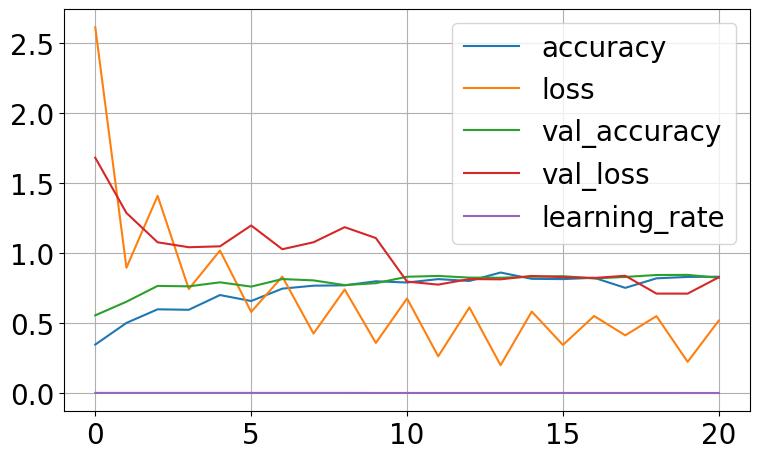

In [36]:

# Create a figure
pd.DataFrame(resnet50_model.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_CNN_ResNet50.pdf')
plt.show()

In [37]:
y_pred = resnet50_pretrained.predict(X_val)
y_pred = [np.argmax(ele) for ele in y_pred]
y_pred = np.array(y_pred)

# Calculate the confusion matrix
y_true = [np.argmax(ele) for ele in y_val]
y_true =  np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

116/116 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step
Confusion Matrix:
[[355   7   0   0   2   1   0   0  33  14]
 [  1 284   0   5   0   0   2   0  47   0]
 [  0   0 286   0   0   0   0   0  62   0]
 [  4   1   0 387   1   0   0   0   5   1]
 [  4   0   0   1 300   6   0  16  67   2]
 [  3   2   0   0   1 375   0   1  12   9]
 [  0   1   0   0   0   0 317   2  72   0]
 [  2   0   0   0   0   5   0 286   3  38]
 [  5   0   6   0   3   1  14  52 237  14]
 [ 47   4   0   0   1  31   0   2  44 208]]


<Axes: >

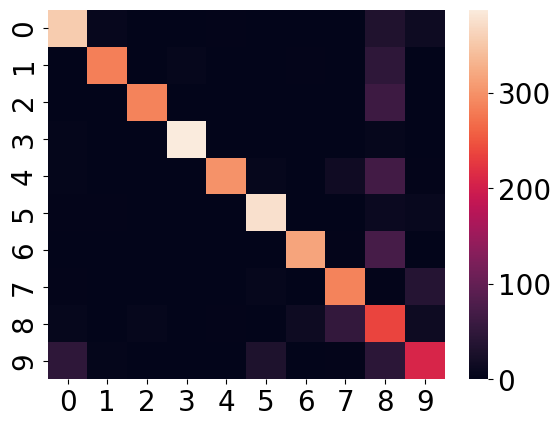

In [38]:
sns.heatmap(conf_matrix)